In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pickle
import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [3]:
#plot regression curve
def plot_regression_results(ax, y_true, y_pred, title,scores):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
#    ax.set_xlim([y_true.min(), y_true.max()])
#    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('NEMD CoF')
    ax.set_ylabel('Predicted CoF')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='best')
#    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)

In [4]:
def plot_RM_pie(feature_importances,t,s,c):
    #normalize to total of feature importances
    total = sum(map(lambda x: x[1], feature_importances))
    print(total)
    #catagorize features into 5 classes
    intra={}
    dents={}
    ordr={}
    dyms={}
    density={}
    for feat in feature_importances:
        if feat[0] in ['CO.double.bonds','tail.double.bonds','tail.side.chains','num.atoms']:
            intra.update({feat[0]:feat[1]})
        if feat[0] in ['bidentbr','monodent','bidentchel']:
            dents.update({feat[0]:feat[1]})
        if feat[0] in ['noofr','nosqu','rgsqu','rgofr']:
            ordr.update({feat[0]:feat[1]})
        if feat[0] in ['ofrD','squD']:
            dyms.update({feat[0]:feat[1]})
#        if feat[0] in ['dens_max_squ','dens_max_bot','dens_max_top','Hz','ofr_bound_z','ofrgap']:
#            density.update({feat[0]:feat[1]})
    #print(intra,dents,ordr,dyms,density)
    #normalize weights of each feature within the catagory
    intra_sum=np.sum(list(intra.values()))/total
    dents_sum=np.sum(list(dents.values()))/total
    ordr_sum=np.sum(list(ordr.values()))/total
    dyms_sum=np.sum(list(dyms.values()))/total
    print(intra_sum,dents_sum,ordr_sum,dyms_sum)
#    density_sum=np.sum(list(density.values()))/total
    #print(intra_sum,dents_sum,ordr_sum,dyms_sum,density_sum)
    sub_sizes = []
    sub_labels = []

    #resize with only first two principles show and the rest stack together
    intra_sub={}
    dents_sub={}
    ordr_sub={}
    dyms_sub={}
#    density_sub={}
    for i,feat in enumerate(intra.keys()):
        a = intra[feat]/total
        intra_sub.update({feat:a})
    for i,feat in enumerate(dents.keys()):
        a = dents[feat]/total
        dents_sub.update({feat:a})
    for i,feat in enumerate(ordr.keys()):
        a = ordr[feat]/total
        ordr_sub.update({feat:a})
    for i,feat in enumerate(dyms.keys()):
        a = dyms[feat]/total
        dyms_sub.update({feat:a})
        
#    sum_a = 0
#    if density_sum<1e-6:
#        density_sub.update({'others':0})
#    else:
#        for i,feat in enumerate(density.keys()):
#            if i < 2:
#                a = density[feat]/total
#                density_sub.update({feat:a})
#            else:
#                sum_a = sum_a + density[feat]/total
#        density_sub.update({'others':sum_a})
    #print(intra_sub,dents_sub,ordr_sub,dyms_sub,density_sub)
    #plot the pie chart
    red = np.divide([float(255), float(0), float(0)],float(255))
    orange = np.divide([float(255), float(165), float(0)],float(255))
    green = np.divide([float(0), float(196), float(64)],float(255))
    blue = np.divide([float(0), float(0), float(255)],float(255))
    gray = np.divide([float(140), float(140), float(140)],float(255))
    white = [1, 1, 1]
    first_colors = [red,orange,green,blue]
    #first_colors = [red,orange,green,blue,gray]

    def make_rgb_transparent(rgb, bg_rgb, alpha):
        return [alpha * c1 + (1 - alpha) * c2
                    for (c1, c2) in zip(rgb, bg_rgb)]
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = ['MOL','DENT','PACK','DYMS']
    #labels = ['I','DENTS','O','DYMS','DES']
    
    sizes = [intra_sum,dents_sum,ordr_sum,dyms_sum]
    #sizes = [intra_sum,dents_sum,ordr_sum,dyms_sum,density_sum]
    #remove others with zero weights
#    if density_sub['others']==0:
#        density_sub.pop('others')
    
    sub_sizes = list(intra_sub.values())+list(dents_sub.values())+list(ordr_sub.values())+list(dyms_sub.values())
    sub_labels = list(intra_sub.keys())+list(dents_sub.keys())+list(ordr_sub.keys())+list(dyms_sub.keys())
    
#    sub_sizes = list(intra_sub.values())+list(dents_sub.values())+list(ordr_sub.values())+list(dyms_sub.values())+list(density_sub.values())
#    sub_labels = list(intra_sub.keys())+list(dents_sub.keys())+list(ordr_sub.keys())+list(dyms_sub.keys())+list(density_sub.keys())
    colorlist =[]
    for i in list(intra_sub.values()):
        #colorlist.append(blue)
        if intra_sum < 1e-6:
            colorlist.append(make_rgb_transparent(red,white,0))
        else:
            colorlist.append(make_rgb_transparent(red,white,i/intra_sum))
    for i in list(dents_sub.values()):
        #colorlist.append(red)
        if dents_sum < 1e-6:
            colorlist.append(make_rgb_transparent(orange,white,0))
        else:
            colorlist.append(make_rgb_transparent(orange,white,i/dents_sum))
    for i in list(ordr_sub.values()):
        #colorlist.append(red)
        if ordr_sum < 1e-6:
            colorlist.append(make_rgb_transparent(green,white,0))
        else:
            colorlist.append(make_rgb_transparent(green,white,i/ordr_sum))
    for i in list(dyms_sub.values()):
        #colorlist.append(red)
        if dyms_sum < 1e-6:
            colorlist.append(make_rgb_transparent(blue,white,0))
        else:
            colorlist.append(make_rgb_transparent(blue,white,i/dyms_sum))
#    for i in list(density_sub.values()):
        #colorlist.append(red)
#        if density_sum < 1e-6:
#            colorlist.append(make_rgb_transparent(red,white,0))
#        else:
#            colorlist.append(make_rgb_transparent(gray,white,i/density_sum))
    plt.rcParams["figure.figsize"] = (15,15)
    fig1, ax1 = plt.subplots()
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.pie(sizes,labels=labels,colors=first_colors,startangle=90,radius=1.3,textprops={'color':'black','fontsize':50},
        wedgeprops={"edgecolor":"1",'linewidth': 3,
                    'linestyle': 'solid', 'antialiased': True})
    ax1.pie(sub_sizes,labels=sub_labels,startangle=90,labeldistance=0.8,colors=colorlist,radius=1.3-0.3,
        textprops={'color':'black','fontsize':50},
        wedgeprops={"edgecolor":"1",'linewidth': 3,
                    'linestyle': 'solid', 'antialiased': True})
    #plt.tight_layout()
    plt.savefig('RM_coef_pie'+str(t)+'-'+str(s)+'ms'+c+'.svg', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=False, bbox_inches='tight', pad_inches=0.1,
        frameon=None, metadata=None)

In [5]:
#Calculate model evaluation metrics
def eval_metrics(test_labels,pred_labels,temp,sp,cov):
    evs=explained_variance_score(test_labels, pred_labels)#, multioutput='uniform_average')
    mse=mean_squared_error(test_labels, pred_labels)
    mrse=np.sqrt(mse)
    me=max_error(test_labels, pred_labels)
    mae=mean_absolute_error(test_labels, pred_labels)#, multioutput='raw_values')
    msle=mean_squared_log_error(test_labels, pred_labels)#,multioutput='raw_values')
    medianae=median_absolute_error(test_labels, pred_labels)#, multioutput='raw_values')
    r2=r2_score(test_labels, pred_labels)#, multioutput='raw_values')
    mpd=mean_poisson_deviance(test_labels, pred_labels)
    mgd=mean_gamma_deviance(test_labels, pred_labels)
    spr, test_p = spearmanr(test_labels,pred_labels)

    evaluation_metrics={'range':[max(test_labels),min(test_labels)],'ExplainedVar':[evs,1],'MaxResErr':[me,0],'MeanAbsErr':[mae,0],'MeanSqdErr':[mse,0],
'MeanSqrtErr':[mrse,0],'MeanSqdLogErr':[msle,0],'MediumAbsErr':[medianae,0.5*(max(test_labels)-min(test_labels))],
                   'r2':[r2,1],'MeanPoisson':[mpd,0],'MeanGamma':[mgd,0],'Spearman':[spr,1]}

    csv_columns = list(evaluation_metrics.keys())
    csv_file='RM_error_'+str(temp)+'-'+str(sp)+'ms'+cov+'.csv'
    with open(csv_file, 'w') as csvfile:
        for key in evaluation_metrics.keys():
            csvfile.write(key+','+str(evaluation_metrics[key][0])+','+str(evaluation_metrics[key][1])+'\n')

In [ ]:
#specify data set
features = pd.read_excel('physprops-noRACs1.xlsx')
temp=45
sp=0.5
cov='med'
features=features.loc[(features['temp']==temp)]
features=features.loc[features['speed']==sp]
features=features.loc[features[cov+'.cov']==1]

In [ ]:
# Labels are the values we want to predict
labels = np.array(features['cof'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop(['OFR','cof','speed','temp','thigh','tmed','tlow',
                         'vhigh','vmed','vlow','low.cov','med.cov',
                        'dens_max_top','dens_max_bot','dens_max_squ',
                        'Hz','ofr_bound_z','ofrgap','noofrtop','noofrbot'], axis = 1)
                        #'CO.double.bonds',
                        # 'tail.double.bonds','tail.side.chains',
                        # 'rgofr','noofrbot','nosqu','noofrtop','ofrD','num.atoms',
                        #'bidentbr','bidentchel','monodent'], axis = 1) #'Hz','ofrgap','ofr_bound_z','rgsqu','squD'

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3,
                                                                           random_state = 42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_median_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(train_features, train_labels)

In [ ]:
best_random = rf_random.best_estimator_

In [ ]:
import pickle
import joblib
# Save the model as a pickle in a file
joblib.dump(best_random, 'best-RM-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.pkl') 

In [ ]:
#rf_new = joblib.load('best-RM-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.pkl') 
rf_new = best_random

In [ ]:
# Get numerical feature importances
importances = list(rf_new.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
plot_RM_pie(feature_importances,temp,sp,cov)

In [ ]:
pred_labels=best_random.predict(test_features)
eval_metrics(test_labels,pred_labels,temp,sp,cov)

In [ ]:
features = pd.read_excel('physprops-noRACs1.xlsx')
#specify data set
temp=45
sp=1
cov='med'
features=features.loc[(features['temp']==temp)]
features=features.loc[features['speed']==sp]
features=features.loc[features[cov+'.cov']==1]

# Labels are the values we want to predict
labels = np.array(features['cof'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop(['OFR','cof','speed','temp','thigh','tmed','tlow',
                         'vhigh','vmed','vlow','low.cov','med.cov',
                        'dens_max_top','dens_max_bot','dens_max_squ',
                        'Hz','ofr_bound_z','ofrgap','noofrtop','noofrbot'], axis = 1)
                        #'CO.double.bonds',
                        # 'tail.double.bonds','tail.side.chains',
                        # 'rgofr','noofrbot','nosqu','noofrtop','ofrD','num.atoms',
                        #'bidentbr','bidentchel','monodent'], axis = 1) #'Hz','ofrgap','ofr_bound_z','rgsqu','squD'

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

# Using Skicit-learn to split data into training and testing sets
#from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3,
                                                                           random_state = 42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
#                              n_iter = 100, scoring='neg_mean_absolute_error', 
#                              cv = 3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
#rf_random.fit(train_features, train_labels)

#best_random = rf_random.best_estimator_
#joblib.dump(best_random, 'best-RM-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.pkl')
rf_new = joblib.load('best-RM-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.pkl')
#rf_new = best_random

# Get numerical feature importances
importances = list(rf_new.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

plot_RM_pie(feature_importances,temp,sp,cov)

pred_labels=best_random.predict(test_features)
eval_metrics(test_labels,pred_labels,temp,sp,cov)

In [ ]:
features = pd.read_excel('physprops-noRACs1.xlsx')
#specify data set
temp=45
sp=10
cov='med'
features=features.loc[(features['temp']==temp)]
features=features.loc[features['speed']==sp]
features=features.loc[features[cov+'.cov']==1]

# Labels are the values we want to predict
labels = np.array(features['cof'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop(['OFR','cof','speed','temp','thigh','tmed','tlow',
                         'vhigh','vmed','vlow','low.cov','med.cov',
                        'dens_max_top','dens_max_bot','dens_max_squ',
                        'Hz','ofr_bound_z','ofrgap','noofrtop','noofrbot'], axis = 1)
                        #'CO.double.bonds',
                        # 'tail.double.bonds','tail.side.chains',
                        # 'rgofr','noofrbot','nosqu','noofrtop','ofrD','num.atoms',
                        #'bidentbr','bidentchel','monodent'], axis = 1) #'Hz','ofrgap','ofr_bound_z','rgsqu','squD'

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

# Using Skicit-learn to split data into training and testing sets
#from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3,
                                                                           random_state = 42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(train_features, train_labels)

best_random = rf_random.best_estimator_
joblib.dump(best_random, 'best-RM-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.pkl') 
#rf_new = joblib.load('best-RM-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.pkl')
rf_new = best_random

# Get numerical feature importances
importances = list(rf_new.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

plot_RM_pie(feature_importances,temp,sp,cov)

pred_labels=best_random.predict(test_features)
eval_metrics(test_labels,pred_labels,temp,sp,cov)

Variable: bidentchel           Importance: 0.45
Variable: nosqu                Importance: 0.11
Variable: ofrD                 Importance: 0.07
Variable: rgsqu                Importance: 0.06
Variable: squD                 Importance: 0.06
Variable: tail.side.chains     Importance: 0.05
Variable: rgofr                Importance: 0.05
Variable: noofr                Importance: 0.05
Variable: tail.double.bonds    Importance: 0.03
Variable: num.atoms            Importance: 0.03
Variable: CO.double.bonds      Importance: 0.02
Variable: monodent             Importance: 0.02
Variable: bidentbr             Importance: 0.0
1.0000000000000004
0.12999999999999995 0.4699999999999998 0.26999999999999985 0.12999999999999995


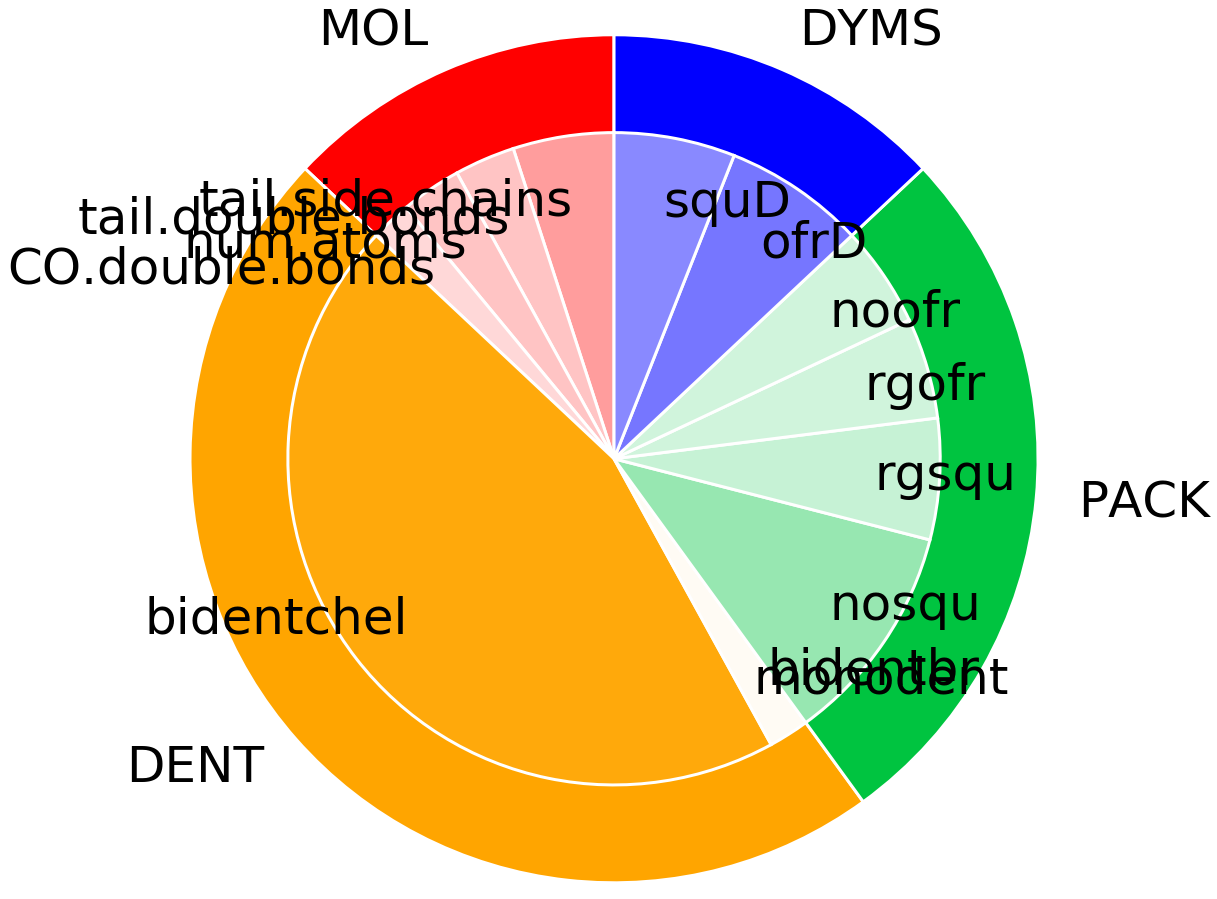

In [6]:
features = pd.read_excel('physprops-noRACs1.xlsx')
#specify data set
temp=120
sp=0.5
cov='low'
features=features.loc[(features['temp']==temp)]
features=features.loc[features['speed']==sp]
features=features.loc[features[cov+'.cov']==1]

# Labels are the values we want to predict
labels = np.array(features['cof'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop(['OFR','cof','speed','temp','thigh','tmed','tlow',
                         'vhigh','vmed','vlow','low.cov','med.cov',
                        'dens_max_top','dens_max_bot','dens_max_squ',
                        'Hz','ofr_bound_z','ofrgap','noofrtop','noofrbot'], axis = 1)
                        #'CO.double.bonds',
                        # 'tail.double.bonds','tail.side.chains',
                        # 'rgofr','noofrbot','nosqu','noofrtop','ofrD','num.atoms',
                        #'bidentbr','bidentchel','monodent'], axis = 1) #'Hz','ofrgap','ofr_bound_z','rgsqu','squD'

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

# Using Skicit-learn to split data into training and testing sets
#from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3,
                                                                           random_state = 42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
#                              n_iter = 100, scoring='neg_mean_absolute_error', 
#                              cv = 3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
#rf_random.fit(train_features, train_labels)

#best_random = rf_random.best_estimator_
#joblib.dump(best_random, 'best-RM-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.pkl') 
#rf_new = best_random
rf_new = joblib.load('best-RM-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.pkl')
# Get numerical feature importances
importances = list(rf_new.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

plot_RM_pie(feature_importances,temp,sp,cov)

pred_labels=rf_new.predict(test_features)
eval_metrics(test_labels,pred_labels,temp,sp,cov)

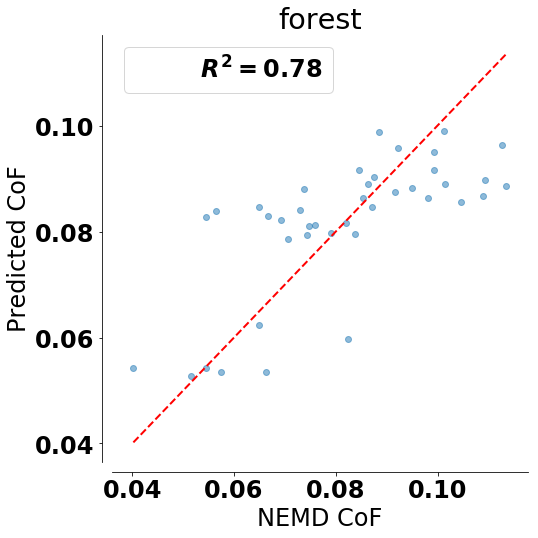

In [8]:
scores, test_p = spearmanr(test_labels,pred_labels)
fig, axs = plt.subplots()
plot_regression_results(
        axs, test_labels,pred_labels,
        "forest",('$R^2={:.2f}$').format(scores))
plt.rc('font', size=24)
plt.rcParams["figure.figsize"] = (8,8)
plt.rc('font',family='sans-serif')
plt.rcParams['font.sans-serif']
plt.rc('font',weight='bold')

plt.tight_layout()


plt.savefig('reg-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.svg', dpi=None, facecolor='w', edgecolor='w',
#plt.savefig('test.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [15]:
joblib.dump(best_random, 'best-RM-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.pkl')

['best-RM-120C-0.5ms-low.pkl']

In [ ]:
features = pd.read_excel('physprops-noRACs1.xlsx')
#specify data set
temp=120
sp=1
cov='med'
features=features.loc[(features['temp']==temp)]
features=features.loc[features['speed']==sp]
features=features.loc[features[cov+'.cov']==1]

# Labels are the values we want to predict
labels = np.array(features['cof'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop(['OFR','cof','speed','temp','thigh','tmed','tlow',
                         'vhigh','vmed','vlow','low.cov','med.cov',
                        'dens_max_top','dens_max_bot','dens_max_squ',
                        'Hz','ofr_bound_z','ofrgap','noofrtop','noofrbot'], axis = 1)
                        #'CO.double.bonds',
                        # 'tail.double.bonds','tail.side.chains',
                        # 'rgofr','noofrbot','nosqu','noofrtop','ofrD','num.atoms',
                        #'bidentbr','bidentchel','monodent'], axis = 1) #'Hz','ofrgap','ofr_bound_z','rgsqu','squD'

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

# Using Skicit-learn to split data into training and testing sets
#from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3,
                                                                           random_state = 42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
#                              n_iter = 100, scoring='neg_mean_absolute_error', 
#                              cv = 3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
#rf_random.fit(train_features, train_labels)

#best_random = rf_random.best_estimator_
#joblib.dump(best_random, 'best-RM-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.pkl') 
#rf_new = best_random
rf_new = joblib.load('best-RM-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.pkl')
# Get numerical feature importances
importances = list(rf_new.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

plot_RM_pie(feature_importances,temp,sp,cov)

pred_labels=best_random.predict(test_features)
eval_metrics(test_labels,pred_labels,temp,sp,cov)

In [ ]:
features = pd.read_excel('physprops-noRACs1.xlsx')
#specify data set
temp=120
sp=10
cov='med'
features=features.loc[(features['temp']==temp)]
features=features.loc[features['speed']==sp]
features=features.loc[features[cov+'.cov']==1]

# Labels are the values we want to predict
labels = np.array(features['cof'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop(['OFR','cof','speed','temp','thigh','tmed','tlow',
                         'vhigh','vmed','vlow','low.cov','med.cov',
                        'dens_max_top','dens_max_bot','dens_max_squ',
                        'Hz','ofr_bound_z','ofrgap','noofrtop','noofrbot'], axis = 1)
                        #'CO.double.bonds',
                        # 'tail.double.bonds','tail.side.chains',
                        # 'rgofr','noofrbot','nosqu','noofrtop','ofrD','num.atoms',
                        #'bidentbr','bidentchel','monodent'], axis = 1) #'Hz','ofrgap','ofr_bound_z','rgsqu','squD'

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

# Using Skicit-learn to split data into training and testing sets
#from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3,
                                                                           random_state = 42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
#                              n_iter = 100, scoring='neg_mean_absolute_error', 
#                              cv = 3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
#rf_random.fit(train_features, train_labels)

#best_random = rf_random.best_estimator_
#joblib.dump(best_random, 'best-RM-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.pkl') 
#rf_new = best_random
rf_new = joblib.load('best-RM-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.pkl')
# Get numerical feature importances
importances = list(rf_new.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

plot_RM_pie(feature_importances,temp,sp,cov)

pred_labels=best_random.predict(test_features)
eval_metrics(test_labels,pred_labels,temp,sp,cov)

In [ ]:
features = pd.read_excel('physprops-noRACs1.xlsx')
#specify data set
temp=150
sp=0.5
cov='med'
features=features.loc[(features['temp']==temp)]
features=features.loc[features['speed']==sp]
features=features.loc[features[cov+'.cov']==1]

# Labels are the values we want to predict
labels = np.array(features['cof'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop(['OFR','cof','speed','temp','thigh','tmed','tlow',
                         'vhigh','vmed','vlow','low.cov','med.cov',
                        'dens_max_top','dens_max_bot','dens_max_squ',
                        'Hz','ofr_bound_z','ofrgap','noofrtop','noofrbot'], axis = 1)
                        #'CO.double.bonds',
                        # 'tail.double.bonds','tail.side.chains',
                        # 'rgofr','noofrbot','nosqu','noofrtop','ofrD','num.atoms',
                        #'bidentbr','bidentchel','monodent'], axis = 1) #'Hz','ofrgap','ofr_bound_z','rgsqu','squD'

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

# Using Skicit-learn to split data into training and testing sets
#from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3,
                                                                           random_state = 42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
#                              n_iter = 100, scoring='neg_mean_absolute_error', 
#                              cv = 3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
#rf_random.fit(train_features, train_labels)

#best_random = rf_random.best_estimator_
#joblib.dump(best_random, 'best-RM-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.pkl') 
#rf_new = best_random
rf_new = joblib.load('best-RM-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.pkl')
# Get numerical feature importances
importances = list(rf_new.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

plot_RM_pie(feature_importances,temp,sp,cov)

pred_labels=best_random.predict(test_features)
eval_metrics(test_labels,pred_labels,temp,sp,cov)

In [ ]:
features = pd.read_excel('physprops-noRACs1.xlsx')
#specify data set
temp=150
sp=1
cov='med'
features=features.loc[(features['temp']==temp)]
features=features.loc[features['speed']==sp]
features=features.loc[features[cov+'.cov']==1]

# Labels are the values we want to predict
labels = np.array(features['cof'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop(['OFR','cof','speed','temp','thigh','tmed','tlow',
                         'vhigh','vmed','vlow','low.cov','med.cov',
                        'dens_max_top','dens_max_bot','dens_max_squ',
                        'Hz','ofr_bound_z','ofrgap','noofrtop','noofrbot'], axis = 1)
                        #'CO.double.bonds',
                        # 'tail.double.bonds','tail.side.chains',
                        # 'rgofr','noofrbot','nosqu','noofrtop','ofrD','num.atoms',
                        #'bidentbr','bidentchel','monodent'], axis = 1) #'Hz','ofrgap','ofr_bound_z','rgsqu','squD'

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

# Using Skicit-learn to split data into training and testing sets
#from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3,
                                                                           random_state = 42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
#                              n_iter = 100, scoring='neg_mean_absolute_error', 
#                              cv = 3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
#rf_random.fit(train_features, train_labels)

#best_random = rf_random.best_estimator_
#joblib.dump(best_random, 'best-RM-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.pkl') 
#rf_new = best_random
rf_new = joblib.load('best-RM-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.pkl')
# Get numerical feature importances
importances = list(rf_new.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

plot_RM_pie(feature_importances,temp,sp,cov)

pred_labels=best_random.predict(test_features)
eval_metrics(test_labels,pred_labels,temp,sp,cov)

In [ ]:
features = pd.read_excel('physprops-noRACs1.xlsx')
#specify data set
temp=150
sp=10
cov='med'
features=features.loc[(features['temp']==temp)]
features=features.loc[features['speed']==sp]
features=features.loc[features[cov+'.cov']==1]

# Labels are the values we want to predict
labels = np.array(features['cof'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop(['OFR','cof','speed','temp','thigh','tmed','tlow',
                         'vhigh','vmed','vlow','low.cov','med.cov',
                        'dens_max_top','dens_max_bot','dens_max_squ',
                        'Hz','ofr_bound_z','ofrgap','noofrtop','noofrbot'], axis = 1)
                        #'CO.double.bonds',
                        # 'tail.double.bonds','tail.side.chains',
                        # 'rgofr','noofrbot','nosqu','noofrtop','ofrD','num.atoms',
                        #'bidentbr','bidentchel','monodent'], axis = 1) #'Hz','ofrgap','ofr_bound_z','rgsqu','squD'

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

# Using Skicit-learn to split data into training and testing sets
#from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3,
                                                                           random_state = 42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
#                              n_iter = 100, scoring='neg_mean_absolute_error', 
#                              cv = 3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
#rf_random.fit(train_features, train_labels)

#best_random = rf_random.best_estimator_
#joblib.dump(best_random, 'best-RM-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.pkl') 
#rf_new = best_random
rf_new = joblib.load('best-RM-'+str(temp)+'C-'+str(sp)+'ms-'+cov+'.pkl')
# Get numerical feature importances
importances = list(rf_new.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

plot_RM_pie(feature_importances,temp,sp,cov)

pred_labels=best_random.predict(test_features)
eval_metrics(test_labels,pred_labels,temp,sp,cov)